In [20]:
import george
from george import kernels
import numpy as np
kernel = 2 * kernels.Matern52Kernel(metric=0.1, ndim=1)
gp = george.GP(kernel)
print(gp.get_parameter_vector())

[ 0.69314718 -2.30258509]


In [30]:
import pandas as pd
import numpy as np
data = pd.read_csv("conf_mat.csv")
print(np.array(data))

[[   1  738  216    0   99    7   57    0    5    2    1]
 [   5   35   93    5    6    3    1    0    0    1    2]
 [   6    0    0   46    0    0    0    0    0    0    0]
 [ 338 1118  914   49 8337 1892 2552   10  110  218  109]
 [  10    2    1    0   10 1302   12    0    1    1   14]
 [  40   81   50    5  106   48  615   37    3   28   78]
 [   0    0    0    0    0    0    0  384    0    0    2]
 [   0    0    0    0    0    0    0    0   45    0    0]
 [   0    0    0    0    0    1    0    0    0   40    5]
 [   0    0    1    1    0    1    1    0    0    5   37]]


In [ ]:
from util import create_dataset 
create_dataset('data/original_dataset_0.60_0.30_0.10', 2500, down_sample=False, aug_val=True,image=False, instance=0, save_weight=True)

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def sequence_to_image(x, y, figsize=(4,4),dpi=32):
    from PIL import Image
    fig = plt.figure(figsize=figsize,dpi=dpi)
    fig.patch.set_facecolor('black')
    plt.scatter(x,y, s=2,c='w')
    plt.axis('off')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0)
    plt.margins(0,0)
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w, h, 4)
    buf = np.roll(buf, 3, axis=2)
    image = Image.frombytes("RGBA", (w, h), buf.tostring())
    image = image.convert('L')
    plt.close('all')
    return image

import pickle
f2 = open('data/split_%dfold_No%d'%(10,2)+'_aug_to_2500_down_sample_True_instance0-9/test_data', 'rb')
X_sequence_test, X_feature_test, Y_test = pickle.load(f2) 
f2.close()
images_test = []
for sequence in X_sequence_test :
    images_test.append(np.array(sequence_to_image(sequence[:,0],sequence[:,1])))


/tmp/ipykernel_13112/4143393231.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
/tmp/ipykernel_13112/4143393231.py:17: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  image = Image.frombytes("RGBA", (w, h), buf.tostring())


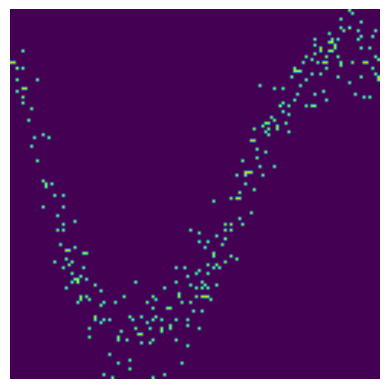

In [49]:
plt.imshow(images_test[21])
plt.axis('off')
plt.savefig('image_instance.png')

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import pickle
import numpy as np

def multi_input_model(sequence_shape, image_shape, feature_shape, num_classes, cnn_lr_lamd=5):

    sequence_inputs = keras.Input(shape=sequence_shape, name='sequence')
    masking_layer = layers.Masking(mask_value=0, name='masking')
    x1 = masking_layer(sequence_inputs)
    x1 = layers.Bidirectional(layers.GRU(128, return_sequences=True, trainable=False), name='Bidirectional',trainable=False)(x1)
    x1 = layers.Bidirectional(layers.GRU(64, trainable=False), name='Bidirectional_1', trainable=False)(x1)
    x1 = layers.Dropout(0.4)(x1)
    x1 = layers.Dense(128, activation="relu", name='dense', trainable=False)(x1)
    x1 = layers.Dropout(0.4)(x1)
    x1 = layers.Dense(32, activation="relu", name='dense_1', trainable=False)(x1)

    image_inputs = keras.Input(shape=image_shape, name='image')
    x2 = layers.Rescaling(scale=1.0 / 255)(image_inputs)
    x2 = layers.Conv2D(filters=4, kernel_size=(7,7), strides=1, activation="relu", padding='same')(x2)
    x2 = layers.Conv2D(filters=4, kernel_size=(5,5), strides=1, activation="relu", padding='same')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3) ,strides=2)(x2)
    x2 = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu")(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.Dense(256, activation="relu", kernel_regularizer='l1', name='cnn_dense')(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.Dense(32, activation="relu", kernel_regularizer='l1', name='cnn_dense_2')(x2)

    feature_inputs = keras.Input(shape=feature_shape, name='feature')
    x3 = feature_inputs
    x3 = layers.Dense(64, activation="relu", name='dense_2', trainable=True)(x3)
    x3 = layers.Dense(32, activation="relu",  name='dense_3', trainable=True)(x3)

    x = layers.concatenate([x1, x2, x3])
    outputs = layers.Dense(num_classes, activation="softmax", name='mix_final_dense')(x)
    model = keras.Model(inputs=[sequence_inputs, image_inputs, feature_inputs], outputs=outputs)
    return model

model = multi_input_model(sequence_shape=(None, 3), image_shape=(128, 128, 1), 
                        feature_shape=(2,), num_classes=11, cnn_lr_lamd=10)
model.compile(
optimizer=keras.optimizers.Adam(1e-3),
loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
run_eagerly=False,
)
callbacks = [
keras.callbacks.ModelCheckpoint(
  filepath='models/bagging_after_image_0.60_0.30_0.10/mix_model%d/model_{epoch}'%6,
  save_freq='epoch'),
keras.callbacks.TensorBoard(log_dir='models/bagging_after_image_0.60_0.30_0.10/mix_model%d/logs'%5)
]
model.load_weights('models/10fold%d/bagging0/rnn_with_feature%d/rnn_weights_min_loss%d.h5'%(0,0,0), by_name=True)
model.summary()

2023-02-06 17:11:50.743584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 17:11:50.836652: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-06 17:11:52.153797: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 1)  0           ['image[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 4)  200         ['rescaling[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 4)  404         ['conv2d[0][0]']             

: 

In [ ]:
a = float('inf')
b = float('nan')
print(a)
from scipy import stats
print(stats.norm.pdf(a))
print(stats.norm.pdf(b))

In [ ]:
import numpy as np
a = np.array([[1,2,2],[3,4,4],[3,4,4]])
b = np.array([[5,6,5],[7,8,6],[7,8,6]])
print(np.stack([a,b],axis=2))
print(np.stack([a,b],axis=2).shape)

In [ ]:
from scipy import stats
print(stats.norm.pdf(-1))

In [ ]:
import numpy as np
from math import isnan
a = np.array([[1,2],[3,float('nan')]])
print(np.sum(a))

In [ ]:
import pickle
import numpy as np
f1 = open('data/split_uncertainty_image_0.60_0.30_0.10_aug_to_3000_down_sample_True_instance0-9/train_data0', 'rb')
X_sequence_train, X_feature_train, X_image_train, X_uncertainty_map, Y_train = pickle.load(f1)
f1.close()

In [ ]:
print(len(X_uncertainty_map))

In [ ]:
from math import isnan
error_list = []
count = 0
for map in X_uncertainty_map:
    if isnan(np.sum(map)):
        error_list.append(map)
        count+=1
print(count)

In [ ]:
print(len(error_list))
import matplotlib.pyplot as plt
plt.imshow(error_list[1])

In [ ]:
from LightCurve import CRTS_VS_LightCurve
from util import get_meta_information
info_file = 'data/SSS_Per_Tab.txt'
info = get_meta_information(info_file)
lc = CRTS_VS_LightCurve()
test_sample1 = 'data/original_data/type/1/3019100001287.dat' 
lc.read_CRTS_dat(test_sample1, id='3019100001287')
period = info.loc[int(lc.id), 'Period']
lc.fold(period, normalize_phase=False)
lc.clean()
# lc.show()

import random
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,period, 200)
image = lc.to_image()
# plt.imshow(image)

import time

lc = lc.generate_GP_simulation(x, phase_shift_ratio=0.5)
t1 = time.time()
uncertainty_map = lc.to_uncertainty_map()
t2 = time.time()
print((t2-t1)*1000)
plt.imshow(uncertainty_map)


In [ ]:
# lc = lc.generate_GP_simulation(x, phase_shift_ratio=0.5)
image = lc.to_image()
plt.imshow(image)

In [ ]:
import numpy as np
x = np.linspace(0,1,10)
print(x)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
x = np.linspace(0,1,300)
y = np.random.standard_normal(300)
figsize=(4,4)
dpi=32
fig = plt.figure(figsize=figsize,dpi=dpi)
fig.patch.set_facecolor('black')
plt.scatter(x,y, s=4,c='w')
plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, right=1, left=0)
plt.margins(0,0)
fig.canvas.draw()
w, h = fig.canvas.get_width_height()
buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
buf.shape = (w, h, 4)
buf = np.roll(buf, 3, axis=2)
image = Image.frombytes("RGBA", (w, h), buf.tostring())
image = image.convert('L')
image.show()

In [ ]:
from util import create_dataset

for i in range(5,10):
    original_dataste = 'data/original_dataset_10fold_No%d'%i
    create_dataset(original_dataste, class_size=15000, down_sample=False,save_weight=True)


In [ ]:

'''
这里有错误，生成的train_data是重复的
'''
from curses import use_default_colors
from util import create_dataset
import pickle
f1 = open('data/original_dataset_0.80_0.10_0.10', 'rb')
train_data, val_data, test_data = pickle.load(f1)
f1.close()
for i in range(0,1):
    create_dataset('data/original_dataset_0.80_0.10_0.10',2500, down_sample=True, instance=i,
        use_pre_load=True, pre_loaded = (train_data, val_data, test_data))

In [ ]:
from util import  create_dataset_exclude_origin_multi_test
create_dataset_exclude_origin_multi_test('data/original_dataset_0.80_0.10_0.10',5000, 
                                            down_sample=True, multi_test=10)

In [ ]:
import pickle
from util import get_sample_cadence
f = open('data/original_dataset_0.80_0.10_0.10', 'rb')
train_data, val_data, test_data = pickle.load(f)
f.close()
flatten_train_data = []
for type in train_data:
    for sample in type:
        flatten_train_data.append(sample)

In [ ]:
lc = flatten_train_data[4474]
lc.show()
x = get_sample_cadence(flatten_train_data, lc.period)
lc_simu = lc.generate_GP_simulation(x)
lc_simu.show()

In [ ]:
a = np.array([[1,2],[3,4]])
b = np.array([[5,6],[7,8]])
b2 = np.array([[5,6],[7,8]])
c = [a,b, b2]
d = np.array(c)
print(type(d))
print(d)
print(d.shape)

In [ ]:
for i in range(0,3):
    print(i)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.random.uniform(0,1,100)
x = np.sort(x)
y = np.linspace(0,1,100)
plt.scatter(x,y)